In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from sda.encoder_image import Encoder
from sda.img_generator import Generator
from sda.rnn_audio import RNN
from sda.encoder_audio import Encoder as AEncoder

from scipy import signal
from skimage import transform as tf
import numpy as np
from PIL import Image
import contextlib
import shutil
import skvideo.io as sio
import scipy.io.wavfile as wav
import ffmpeg
import face_alignment
from pydub import AudioSegment
import pydub
from pydub.utils import mediainfo

import glob

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device = torch.device("cuda:0")

Random Seed:  999


In [2]:

# number of real samples from video to check with discriminator
D1_SAMPLES = 40


# Learning rate for optimizers
LR = 0.0001

# Beta1 hyperparam for Adam optimizers
BETA1 = 0.5

# grab the names of the pre-processed video files
video_filenames_proc = glob.glob('/home/jarrod/dev/speech-driven-animation/data/aligned_faces/*.npy')

# delete bad entries
bad_files = ['bgit2n', 'lbij7a', 'lrbr3s', 'pbio7a', 'sbaa4p', 'sgwp8p', 'sbim8p', 
             'srwi5a', 'swao7a', 'srbb4n', 'sbbbzp', 'lrae3s']

for i,f in enumerate(video_filenames_proc):
    
    for bad in bad_files:
        if f.find(bad) != -1:
            del video_filenames_proc[i]
            break

In [3]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Network

In [4]:
class getDataSample():
    def __init__(self, model_path="grid", gpu=-1):

        self.audio_path = '/home/jarrod/dev/speech-driven-animation/data/npy_audio_crop/'
        self.device = torch.device("cuda:" + str(gpu))

        self.mean_face = np.load('./data/mean_face.npy')
        self.img_size = (128,96)
        self.aux_latent = 10
        self.sequential_noise = True
    
        rnn_gen_dim = 256
        id_enc_dim = 128
        aud_enc_dim = 256
        audio_feat_len = 0.2
        self.audio_rate = 50000
        self.video_rate = 25
        self.audio_feat_samples = 10000
        self.conversion_dict = {'s16': np.int16, 's32': np.int32}
        
        # image preprocessing
        self.img_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.img_size[0], self.img_size[1])),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def preprocess_img(self, img):
        src = self.fa.get_landmarks(img)[0][self.stablePntsIDs, :]
        dst = self.mean_face[self.stablePntsIDs, :]
        tform = tf.estimate_transform('similarity', src, dst)  # find the transformation matrix
        warped = tf.warp(img, inverse_map=tform.inverse, output_shape=self.img_size)  # wrap the frame image
        warped = warped * 255  # note output from wrap is double image (value range [0,1])
        warped = warped.astype('uint8')

        return warped

    def __call__(self, filename, num_d1_samples, fs=None, aligned=False):
        
        audio_filename = self.audio_path + filename.split('/')[-1].split('.npy')[0] + '.wav.npy'
        
       
        vid_data = np.load(filename)
        frame = np.copy(vid_data[0])
                
        # take the input image and preprocess it    
        frame = self.img_transform(frame)
            
        frame = frame.unsqueeze(0)
        
        # Load preprocessed audio data
        audio_feat_seq = np.load(audio_filename)   
        audio_feat_seq = torch.Tensor(audio_feat_seq)
        audio_feat_seq_length = audio_feat_seq.shape[1]
        
        samp = np.random.rand(num_d1_samples)*num_d1_samples
        samp = samp.astype(int)

        d1_frames = vid_data[samp]
        
        new_d1_frames = []
        
        for i, img in enumerate(d1_frames):
            new_d1_frames.append(self.img_transform(d1_frames[i]))
            
        # concatenate an id_frame for each sample frame going into the frame discriminator    
        new_d1_frames = torch.stack(new_d1_frames)  
        frame_c = frame.repeat(num_d1_samples,1,1,1)     
        new_d1_frames = torch.cat((new_d1_frames, frame_c), axis=1)
        
        vid_data = torch.Tensor(vid_data).permute(0,3,1,2)
        
        return audio_feat_seq, audio_feat_seq_length, frame, vid_data, new_d1_frames

In [5]:
class videoGenerator(nn.Module):
    def __init__(self, gpu=-1):
        
        super(videoGenerator, self).__init__()
            
        self.device = torch.device("cuda:" + str(gpu))    
        
        # size of noise vector
        self.aux_latent = 10
        self.sequential_noise = True
        self.img_size = (128,96)
        self.rnn_gen_dim = 256
        self.id_enc_dim = 128
        self.aud_enc_dim = 256
        self.audio_feat_len = 0.2
        self.audio_rate = 50000

        # audio encoder
        self.encoder = RNN(self.audio_feat_len, self.aud_enc_dim, self.rnn_gen_dim,
                           self.audio_rate, init_kernel=0.005, init_stride=0.001)
        

        # id_image encoder
        self.encoder_id = Encoder(self.id_enc_dim, self.img_size)
        skip_channels = list(self.encoder_id.channels)
        skip_channels.reverse()

        # generator
        self.generator = Generator(self.img_size, self.rnn_gen_dim, condition_size=self.id_enc_dim,
                                   num_gen_channels=self.encoder_id.channels[-1],
                                   skip_channels=skip_channels, aux_size=self.aux_latent,
                                   sequential_noise=self.sequential_noise)
        
    def _broadcast_elements_(self, batch, repeat_no):
        total_tensors = []
        for i in range(0, batch.size()[0]):
            total_tensors += [torch.stack(repeat_no * [batch[i]])]

        return torch.stack(total_tensors)    
    
    
    def forward(self, audio_feat_seq, audio_feat_seq_length, frame):
        
        # create audio encoding from the RNN
        z = self.encoder(audio_feat_seq, [audio_feat_seq_length])  # Encoding for the motion
        
        # generate the noise input for the generator
        noise = torch.FloatTensor(1, audio_feat_seq_length, self.aux_latent).normal_(0, 0.33).to(self.device)
        
        # create encoding from image
        z_id, skips = self.encoder_id(frame, retain_intermediate=True)
        
        # the decoder is abstracted from the encoder, so pass the intermediate outputs of each
        # conv layer (the skips) to the generator (which is the decoder)
        skip_connections = []
        for skip_variable in skips:
            skip_connections.append(self._broadcast_elements_(skip_variable, z.size()[1]))
        skip_connections.reverse()

        z_id = self._broadcast_elements_(z_id, z.size()[1])
        gen_video = self.generator(z, c=z_id, aux=noise, skip=skip_connections)
        
        return gen_video

In [6]:
class frameDiscriminator(nn.Module):
    def __init__(self):
        # takes as input a tensor of shape [num frames, 6, height, width]
        super(frameDiscriminator, self).__init__()
        # number of channels = 3 id_frame, and 3 target frame
        self.nc = 6
        self.ndf = 64
        
        self.main = nn.Sequential(
            # input is (nc) x 96 x 128
            nn.Conv2d(self.nc, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 48 x 64
            nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
           
            # state size. (ndf*2) x 24 x 32
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 12 x 16
            nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 6 x 8
            nn.Conv2d(self.ndf * 8, self.ndf * 8, 4, 1, 0, bias=False),
        )
        self.fc1 = nn.Linear(self.ndf*8*5*3, 1)
        self.output = nn.Sigmoid()

    def forward(self, x):
        x = self.main(x)

        x = x.view(-1, self.ndf*8*5*3)
        x = self.fc1(x)
        
        return self.output(x) 

In [7]:
class seqDiscriminator(nn.Module):
    def __init__(self):
        # takes as input a tensor of shape [num frames, 6, height, width]
        super(seqDiscriminator, self).__init__()
        # number of channels = 3 id_frame, and 3 target frame
        self.nc_vid = 225
        self.ndf_vid = 64
        
        self.vid = nn.Sequential(
            # input is (nc) x 96 x 128
            nn.Conv2d(self.nc_vid, self.ndf_vid, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 48 x 64
            nn.Conv2d(self.ndf_vid, self.ndf_vid * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf_vid * 2),
            nn.LeakyReLU(0.2, inplace=True),
           
            # state size. (ndf*2) x 24 x 32
            nn.Conv2d(self.ndf_vid * 2, self.ndf_vid * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf_vid * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf_vid*4) x 12 x 16
            nn.Conv2d(self.ndf_vid * 4, self.ndf_vid * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf_vid * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf_vid*8) x 6 x 8
            nn.Conv2d(self.ndf_vid * 8, self.ndf_vid * 8, 4, 1, 0, bias=False),
        )
        
        self.nc_aud = 75
        self.ndf_aud = 64
        
        self.aud = nn.Sequential(
            # input is (nc) x 10000 x 1
            nn.Conv1d(self.nc_aud, self.ndf_aud, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf_aud) x 48 x 64
            nn.Conv1d(self.ndf_aud, self.ndf_aud * 2, 4, 2, 1, bias=False),
            nn.BatchNorm1d(self.ndf_aud * 2),
            nn.LeakyReLU(0.2, inplace=True),
           
            # state size. (ndf_aud*2) x 24 x 32
            nn.Conv1d(self.ndf_aud * 2, self.ndf_aud * 4, 4, 2, 1, bias=False),
            nn.BatchNorm1d(self.ndf_aud * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf_aud*4) x 12 x 16
            nn.Conv1d(self.ndf_aud * 4, self.ndf_aud * 8, 5, 2, 1, bias=False),
            nn.BatchNorm1d(self.ndf_aud * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf_aud*8) x 6 x 8
            nn.Conv1d(self.ndf_aud * 8, self.ndf_aud * 8, 5, 2, 1, bias=False),
            nn.BatchNorm1d(self.ndf_aud * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(self.ndf_aud * 8, self.ndf_aud * 8, 5, 4, 1, bias=False),
            nn.BatchNorm1d(self.ndf_aud * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(self.ndf_aud * 8, self.ndf_aud * 8, 3, 4, 1, bias=False),
            nn.BatchNorm1d(self.ndf_aud * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(self.ndf_aud * 8, self.ndf_aud * 8, 3, 4, 1, bias=False),
            nn.BatchNorm1d(self.ndf_aud * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.output = nn.Sequential(
            nn.Linear(10240, 512),
            nn.BatchNorm1d(1),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )
        

    def forward(self, x_vid, x_aud):
        x_vid = self.vid(x_vid)
        x_aud = self.aud(x_aud)

        x_aud = x_aud.unsqueeze(3)
        
        x_con = torch.cat((x_vid, x_aud), axis=3)

        x_con = x_con.view(-1, 1, 512*5*4)

        x_con = self.output(x_con).squeeze()
        
        return x_con

# Initialize Networks and Data Structures

In [8]:
va = getDataSample(gpu=0, model_path="grid")

frameD = frameDiscriminator().to(device)
frameD.apply(weights_init)

# seqD = seqDiscriminator().to(device)
# seqD.apply(weights_init)

netG = videoGenerator(gpu=0).to(device)
netG.apply(weights_init)

criterion = nn.BCELoss()

optimizerD1 = optim.Adam(frameD.parameters(), lr=1e-4, betas=(BETA1, 0.999))
# optimizerD2 = optim.Adam(seqD.parameters(), lr=5e-5, betas=(BETA1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=2e-4, betas=(BETA1, 0.999))

# Training Loop

In [9]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

NUM_EPOCHS = 10

print("Starting Training Loop...")
# For each epoch
for epoch in range(NUM_EPOCHS):
    
    np.random.shuffle(video_filenames_proc)
    
    # For each batch in the dataloader
    for i, filename in enumerate(video_filenames_proc):

        size_test = np.load(filename)
        if size_test.shape[0] < 75:
            continue
        
        ############################
        # (1) Update id_frame D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        frameD.zero_grad()
#         seqD.zero_grad()
        
        ## Train with all-real batch
                
        # Format batch
        a1, a1_size, frame, vid, d1_frames = va(filename, D1_SAMPLES, aligned=True)
        
        a1 = a1.to(device)
        a1.requires_grad = True
        frame = frame.to(device)
        frame.requires_grad = True
        d1_frames = d1_frames.to(device)
        d1_frames.requires_grad = True
        
        
        # Forward pass real batch through frameD
        frame_output = frameD(d1_frames).view(-1)
        
        print(frame_output.shape)
        
        
        
        frameD_x = frame_output.mean().item()
        
        # Calculate loss on all-real batch
        # we're checking d1_samples images for each forward pass
        real_label = torch.full((D1_SAMPLES,), 1, device=device)
        errD_real = criterion(frame_output, real_label)
        # Calculate gradients for D in backward pass
        
        errD_real.backward()
        
  
        ## forward pass through seqD
#         a1 = a1.squeeze(3)
#         vid = vid.reshape(1,-1,128,96)
#         vid = vid.to(device)
#         vid.requires_grad = True
        
#         seq_output = seqD(vid, a1).view(-1)
#         seqD_x = seq_output.mean().item()

#         # Calculate loss on all-real batch
#         seq_real_label = torch.full((1,), 1, device=device)
#         err_seqD_real = criterion(seq_output, seq_real_label)
        
#         # Calculate gradients for D in backward pass
#         err_seqD_real.backward()
        
        
        ## Train with all-fake batch
        
        # Generate fake image batch with G
        fake = netG(a1, a1_size, frame)
        
        # don't want to descriminate all frames, just a subset
        samp = np.random.rand(D1_SAMPLES)*D1_SAMPLES
        samp = samp.astype(int)
        fake_samp = fake[samp]
        
        # concatenate id_frame
        frame_c = frame.repeat(fake_samp.shape[0],1,1,1)     
        fake_samp = torch.cat((fake_samp, frame_c), axis=1)
        
        
        ### Classify all fake batch with frameD
        frame_output = frameD(fake_samp.detach()).view(-1)
        D_G_z1 = frame_output.mean().item()
        
        # Calculate frameD's loss on the all-fake batch
        fake_label = torch.full((fake_samp.shape[0],), 0, device=device)
        errD_fake = criterion(frame_output, fake_label)
        # Calculate the gradients for this batch
        errD_fake.backward()
       
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD1.step()
        
        ### fake batch into seqD
        
#         fake_vid = fake.reshape(1,-1,128,96)
    
#         seq_output = seqD(fake_vid.detach(), a1).view(-1)
#         seqD_G_z1 = seq_output.mean().item()
        
#         # Calculate seqD's loss on the all-fake batch
#         seq_fake_label = torch.full((1,), 0, device=device)
#         err_seqD_fake = criterion(seq_output, seq_fake_label)
#         # Calculate the gradients for this batch
#         err_seqD_fake.backward()
        
#         # Add the gradients from the all-real and all-fake batches
#         err_seqD = err_seqD_real + err_seqD_fake
#         # Update D
#         optimizerD2.step()
        
        
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = frameD(fake_samp).view(-1)
        # Calculate G's loss based on this output
        real_label = torch.full((fake_samp.shape[0],), 1, device=device)   
        errG = criterion(output, real_label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        
        
        
        ## update G with sequencer gradient
    
#         seq_output = seqD(fake_vid.detach(), a1).view(-1)
#         seq_real_label = torch.full((1,), 1, device=device)
#         err_seqG = criterion(seq_output, seq_real_label)
#         err_seqG.backward()
#         seqD_G_z2 = seq_output.mean().item()
        
#         # turn dat crank
        optimizerG.step()
        
        seqD_x, seqD_G_z1, seqD_G_z2 = 0,0,0
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tframeD(x): %.4f\tD(G(z)): %.4f / %.4f \
                  \tseqD(x): %.4f\tseqD(G(z)): %.4f / %.4f: '
                  % (epoch, NUM_EPOCHS, i, len(video_filenames_proc),
                     errD.item(), errG.item(), frameD_x, D_G_z1, D_G_z2, seqD_x, seqD_G_z1, seqD_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS-1) and (i == len(video_filenames_proc)-1)):
            with torch.no_grad():
                fake = netG(a1, a1_size,frame).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
torch.Size([40])
[0/10][0/2987]	Loss_D: 1.2747	Loss_G: 12.3164	frameD(x): 0.7203	D(G(z)): 0.6109 / 0.0000                   	seqD(x): 0.0000	seqD(G(z)): 0.0000 / 0.0000: 
torch.Size([40])
torch.Size([40])


RuntimeError: CUDA error: device-side assert triggered

In [29]:
a1.shape

torch.Size([1, 75, 10000])

In [26]:
fake.shape

torch.Size([40, 6, 128, 96])

# Debug

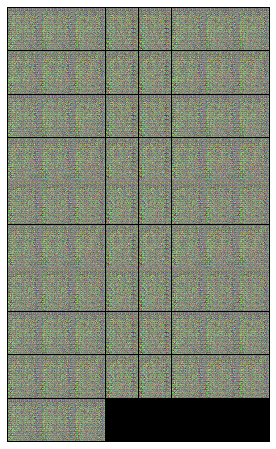

In [64]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Audio Cropping (Rough)

In [ ]:
# the videos are 3s each, but the audio doesn't fill this timespan
# may be necessary to crop the video to the audio, and re-align

In [68]:
audio_path = '/home/jarrod/dev/speech-driven-animation/data/npy_audio/'

audio_filename = audio_path + video_filenames_proc[0].split('/')[-1].split('.npy')[0] + '.wav.npy'

In [70]:
audio_filename,video_filenames_proc[0]

('/home/jarrod/dev/speech-driven-animation/data/npy_audio/bgwu5s.wav.npy',
 '/home/jarrod/dev/speech-driven-animation/data/aligned_faces/bgwu5s.npy')

In [74]:
for f in video_filenames_proc:
    audio_filename = audio_path + f.split('/')[-1].split('.npy')[0] + '.wav.npy'
    test = np.load(audio_filename)
    print(test.shape)

(1, 63, 10000, 1)
(1, 37, 10000, 1)
(1, 55, 10000, 1)
(1, 45, 10000, 1)
(1, 44, 10000, 1)
(1, 43, 10000, 1)
(1, 32, 10000, 1)
(1, 57, 10000, 1)
(1, 40, 10000, 1)
(1, 62, 10000, 1)
(1, 34, 10000, 1)
(1, 59, 10000, 1)
(1, 47, 10000, 1)
(1, 40, 10000, 1)
(1, 45, 10000, 1)
(1, 41, 10000, 1)
(1, 55, 10000, 1)
(1, 43, 10000, 1)
(1, 54, 10000, 1)
(1, 55, 10000, 1)
(1, 50, 10000, 1)
(1, 57, 10000, 1)
(1, 49, 10000, 1)
(1, 58, 10000, 1)
(1, 43, 10000, 1)
(1, 47, 10000, 1)
(1, 59, 10000, 1)
(1, 54, 10000, 1)
(1, 54, 10000, 1)
(1, 37, 10000, 1)
(1, 39, 10000, 1)
(1, 57, 10000, 1)
(1, 46, 10000, 1)
(1, 39, 10000, 1)
(1, 44, 10000, 1)
(1, 31, 10000, 1)
(1, 50, 10000, 1)
(1, 45, 10000, 1)
(1, 43, 10000, 1)
(1, 41, 10000, 1)
(1, 37, 10000, 1)
(1, 41, 10000, 1)
(1, 49, 10000, 1)
(1, 54, 10000, 1)
(1, 35, 10000, 1)
(1, 34, 10000, 1)
(1, 52, 10000, 1)
(1, 65, 10000, 1)
(1, 57, 10000, 1)
(1, 59, 10000, 1)
(1, 47, 10000, 1)
(1, 46, 10000, 1)
(1, 41, 10000, 1)
(1, 34, 10000, 1)
(1, 62, 10000, 1)
(1, 54, 10

(1, 41, 10000, 1)
(1, 51, 10000, 1)
(1, 48, 10000, 1)
(1, 41, 10000, 1)
(1, 50, 10000, 1)
(1, 44, 10000, 1)
(1, 53, 10000, 1)
(1, 39, 10000, 1)
(1, 56, 10000, 1)
(1, 50, 10000, 1)
(1, 35, 10000, 1)
(1, 36, 10000, 1)
(1, 34, 10000, 1)
(1, 35, 10000, 1)
(1, 37, 10000, 1)
(1, 36, 10000, 1)
(1, 44, 10000, 1)
(1, 44, 10000, 1)
(1, 36, 10000, 1)
(1, 63, 10000, 1)
(1, 40, 10000, 1)
(1, 46, 10000, 1)
(1, 55, 10000, 1)
(1, 46, 10000, 1)
(1, 45, 10000, 1)
(1, 33, 10000, 1)
(1, 35, 10000, 1)
(1, 58, 10000, 1)
(1, 41, 10000, 1)
(1, 36, 10000, 1)
(1, 55, 10000, 1)
(1, 60, 10000, 1)
(1, 35, 10000, 1)
(1, 41, 10000, 1)
(1, 41, 10000, 1)
(1, 56, 10000, 1)
(1, 37, 10000, 1)
(1, 41, 10000, 1)
(1, 41, 10000, 1)
(1, 54, 10000, 1)
(1, 54, 10000, 1)
(1, 49, 10000, 1)
(1, 55, 10000, 1)
(1, 35, 10000, 1)
(1, 41, 10000, 1)
(1, 45, 10000, 1)
(1, 55, 10000, 1)
(1, 37, 10000, 1)
(1, 45, 10000, 1)
(1, 46, 10000, 1)
(1, 54, 10000, 1)
(1, 32, 10000, 1)
(1, 43, 10000, 1)
(1, 37, 10000, 1)
(1, 42, 10000, 1)
(1, 58, 10

(1, 48, 10000, 1)
(1, 39, 10000, 1)
(1, 57, 10000, 1)
(1, 51, 10000, 1)
(1, 30, 10000, 1)
(1, 43, 10000, 1)
(1, 61, 10000, 1)
(1, 44, 10000, 1)
(1, 52, 10000, 1)
(1, 58, 10000, 1)
(1, 58, 10000, 1)
(1, 45, 10000, 1)
(1, 35, 10000, 1)
(1, 41, 10000, 1)
(1, 54, 10000, 1)
(1, 37, 10000, 1)
(1, 53, 10000, 1)
(1, 59, 10000, 1)
(1, 40, 10000, 1)
(1, 55, 10000, 1)
(1, 38, 10000, 1)
(1, 41, 10000, 1)
(1, 43, 10000, 1)
(1, 51, 10000, 1)
(1, 43, 10000, 1)
(1, 44, 10000, 1)
(1, 57, 10000, 1)
(1, 33, 10000, 1)
(1, 42, 10000, 1)
(1, 34, 10000, 1)
(1, 34, 10000, 1)
(1, 44, 10000, 1)
(1, 50, 10000, 1)
(1, 40, 10000, 1)
(1, 33, 10000, 1)
(1, 46, 10000, 1)
(1, 46, 10000, 1)
(1, 53, 10000, 1)
(1, 54, 10000, 1)
(1, 36, 10000, 1)
(1, 43, 10000, 1)
(1, 40, 10000, 1)
(1, 36, 10000, 1)
(1, 34, 10000, 1)
(1, 39, 10000, 1)
(1, 59, 10000, 1)
(1, 53, 10000, 1)
(1, 43, 10000, 1)
(1, 44, 10000, 1)
(1, 49, 10000, 1)
(1, 43, 10000, 1)
(1, 38, 10000, 1)
(1, 36, 10000, 1)
(1, 55, 10000, 1)
(1, 40, 10000, 1)
(1, 47, 10

(1, 55, 10000, 1)
(1, 34, 10000, 1)
(1, 58, 10000, 1)
(1, 33, 10000, 1)
(1, 51, 10000, 1)
(1, 58, 10000, 1)
(1, 45, 10000, 1)
(1, 50, 10000, 1)
(1, 47, 10000, 1)
(1, 42, 10000, 1)
(1, 44, 10000, 1)
(1, 53, 10000, 1)
(1, 33, 10000, 1)
(1, 40, 10000, 1)
(1, 34, 10000, 1)
(1, 42, 10000, 1)
(1, 36, 10000, 1)
(1, 43, 10000, 1)
(1, 53, 10000, 1)
(1, 51, 10000, 1)
(1, 33, 10000, 1)
(1, 56, 10000, 1)
(1, 36, 10000, 1)
(1, 58, 10000, 1)
(1, 33, 10000, 1)
(1, 30, 10000, 1)
(1, 34, 10000, 1)
(1, 50, 10000, 1)
(1, 57, 10000, 1)
(1, 35, 10000, 1)
(1, 48, 10000, 1)
(1, 42, 10000, 1)
(1, 58, 10000, 1)
(1, 57, 10000, 1)
(1, 47, 10000, 1)
(1, 53, 10000, 1)
(1, 50, 10000, 1)
(1, 44, 10000, 1)
(1, 48, 10000, 1)
(1, 29, 10000, 1)
(1, 59, 10000, 1)
(1, 54, 10000, 1)
(1, 35, 10000, 1)
(1, 57, 10000, 1)
(1, 49, 10000, 1)
(1, 44, 10000, 1)
(1, 48, 10000, 1)
(1, 41, 10000, 1)
(1, 44, 10000, 1)
(1, 31, 10000, 1)
(1, 47, 10000, 1)
(1, 36, 10000, 1)
(1, 52, 10000, 1)
(1, 51, 10000, 1)
(1, 38, 10000, 1)
(1, 49, 10

(1, 47, 10000, 1)
(1, 44, 10000, 1)
(1, 57, 10000, 1)
(1, 45, 10000, 1)
(1, 70, 10000, 1)
(1, 40, 10000, 1)
(1, 41, 10000, 1)
(1, 43, 10000, 1)
(1, 45, 10000, 1)
(1, 47, 10000, 1)
(1, 48, 10000, 1)
(1, 33, 10000, 1)
(1, 43, 10000, 1)
(1, 41, 10000, 1)
(1, 53, 10000, 1)
(1, 40, 10000, 1)
(1, 34, 10000, 1)
(1, 47, 10000, 1)
(1, 45, 10000, 1)
(1, 28, 10000, 1)
(1, 42, 10000, 1)
(1, 44, 10000, 1)
(1, 49, 10000, 1)
(1, 40, 10000, 1)
(1, 55, 10000, 1)
(1, 51, 10000, 1)
(1, 48, 10000, 1)
(1, 53, 10000, 1)
(1, 49, 10000, 1)
(1, 50, 10000, 1)
(1, 59, 10000, 1)
(1, 45, 10000, 1)
(1, 59, 10000, 1)
(1, 44, 10000, 1)
(1, 52, 10000, 1)
(1, 35, 10000, 1)
(1, 40, 10000, 1)
(1, 36, 10000, 1)
(1, 36, 10000, 1)
(1, 62, 10000, 1)
(1, 49, 10000, 1)
(1, 45, 10000, 1)
(1, 46, 10000, 1)
(1, 33, 10000, 1)
(1, 40, 10000, 1)
(1, 59, 10000, 1)
(1, 46, 10000, 1)
(1, 48, 10000, 1)
(1, 59, 10000, 1)
(1, 35, 10000, 1)
(1, 36, 10000, 1)
(1, 55, 10000, 1)
(1, 53, 10000, 1)
(1, 39, 10000, 1)
(1, 45, 10000, 1)
(1, 45, 10

(1, 34, 10000, 1)
(1, 47, 10000, 1)
(1, 35, 10000, 1)
(1, 43, 10000, 1)
(1, 36, 10000, 1)
(1, 58, 10000, 1)
(1, 50, 10000, 1)
(1, 39, 10000, 1)
(1, 42, 10000, 1)
(1, 45, 10000, 1)
(1, 35, 10000, 1)
(1, 37, 10000, 1)
(1, 34, 10000, 1)
(1, 46, 10000, 1)
(1, 40, 10000, 1)
(1, 37, 10000, 1)
(1, 44, 10000, 1)
(1, 43, 10000, 1)
(1, 63, 10000, 1)
(1, 46, 10000, 1)
(1, 43, 10000, 1)
(1, 53, 10000, 1)
(1, 33, 10000, 1)
(1, 36, 10000, 1)
(1, 56, 10000, 1)
(1, 45, 10000, 1)
(1, 71, 10000, 1)
(1, 32, 10000, 1)
(1, 30, 10000, 1)
(1, 45, 10000, 1)
(1, 49, 10000, 1)
(1, 50, 10000, 1)
(1, 41, 10000, 1)
(1, 30, 10000, 1)
(1, 35, 10000, 1)
(1, 39, 10000, 1)
(1, 46, 10000, 1)
(1, 45, 10000, 1)
(1, 45, 10000, 1)
(1, 55, 10000, 1)
(1, 56, 10000, 1)
(1, 46, 10000, 1)
(1, 33, 10000, 1)
(1, 33, 10000, 1)
(1, 49, 10000, 1)
(1, 33, 10000, 1)
(1, 44, 10000, 1)
(1, 37, 10000, 1)
(1, 46, 10000, 1)
(1, 36, 10000, 1)
(1, 36, 10000, 1)
(1, 46, 10000, 1)
(1, 37, 10000, 1)
(1, 47, 10000, 1)
(1, 41, 10000, 1)
(1, 42, 10

(1, 46, 10000, 1)
(1, 48, 10000, 1)
(1, 34, 10000, 1)
(1, 44, 10000, 1)
(1, 52, 10000, 1)
(1, 49, 10000, 1)
(1, 33, 10000, 1)
(1, 50, 10000, 1)
(1, 41, 10000, 1)
(1, 40, 10000, 1)
(1, 45, 10000, 1)
(1, 40, 10000, 1)
(1, 48, 10000, 1)
(1, 34, 10000, 1)
(1, 50, 10000, 1)
(1, 47, 10000, 1)
(1, 44, 10000, 1)
(1, 36, 10000, 1)
(1, 36, 10000, 1)
(1, 42, 10000, 1)
(1, 38, 10000, 1)
(1, 32, 10000, 1)
(1, 35, 10000, 1)
(1, 40, 10000, 1)
(1, 50, 10000, 1)
(1, 46, 10000, 1)
(1, 54, 10000, 1)
(1, 57, 10000, 1)
(1, 37, 10000, 1)
(1, 57, 10000, 1)
(1, 33, 10000, 1)
(1, 49, 10000, 1)
(1, 37, 10000, 1)
(1, 47, 10000, 1)
(1, 43, 10000, 1)
(1, 43, 10000, 1)
(1, 46, 10000, 1)
(1, 42, 10000, 1)
(1, 43, 10000, 1)
(1, 42, 10000, 1)
(1, 50, 10000, 1)
(1, 30, 10000, 1)
(1, 55, 10000, 1)
(1, 35, 10000, 1)
(1, 41, 10000, 1)
(1, 51, 10000, 1)
(1, 36, 10000, 1)
(1, 56, 10000, 1)
(1, 52, 10000, 1)
(1, 50, 10000, 1)
(1, 35, 10000, 1)
(1, 51, 10000, 1)
(1, 43, 10000, 1)
(1, 58, 10000, 1)
(1, 38, 10000, 1)
(1, 57, 10

In [72]:
vid_data = sio.vread(f.split('.wav')[0] + ".mpg")

(75, 128, 96, 3)

In [76]:
audio_filenames = glob.glob('/home/jarrod/dev/speech-driven-animation/data/*/*.wav')

In [80]:
for f in audio_filenames:
    
    vid_data = sio.vread(f.split('.wav')[0] + ".mpg")
    
    if vid_data.shape[0] != 75:
    
        print(f.split('.wav')[0] + ".mpg")
        print(vid_data.shape)

/home/jarrod/dev/speech-driven-animation/data/s3/sbaa4p.mpg
(74, 288, 360, 3)
/home/jarrod/dev/speech-driven-animation/data/s3/sgwp8p.mpg
(74, 288, 360, 3)
/home/jarrod/dev/speech-driven-animation/data/s3/sbim8p.mpg
(74, 288, 360, 3)
/home/jarrod/dev/speech-driven-animation/data/s1/srwi5a.mpg
(74, 288, 360, 3)
/home/jarrod/dev/speech-driven-animation/data/s1/swao7a.mpg
(74, 288, 360, 3)
/home/jarrod/dev/speech-driven-animation/data/s1/srbb4n.mpg
(74, 288, 360, 3)
/home/jarrod/dev/speech-driven-animation/data/s1/sbbbzp.mpg
(74, 288, 360, 3)
/home/jarrod/dev/speech-driven-animation/data/s1/lrae3s.mpg
(74, 288, 360, 3)


In [81]:
from moviepy.editor import *

In [217]:
video = VideoFileClip(audio_filenames[1000].split('.wav')[0] + '.mpg')
audio = video.audio
# audio.write_audiofile('test.wav')
test = audio.to_soundarray(fps=44100).mean(axis=1)

In [218]:
test.shape

(132300,)

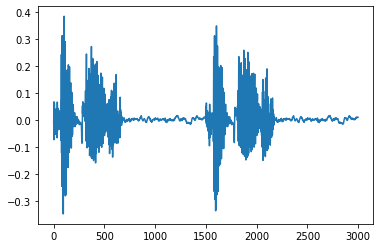

In [214]:
plt.plot(test)

In [185]:
for i, s in enumerate(test):
    if np.abs(s) > 0.03:
        left = i
        break

        
for i, s in enumerate(test[::-1]):
    if np.abs(s) > 0.03:
        right = test.shape[0] - i
        break

num_frames = video.fps * video.duration    

spf = num_frames / test.shape[0]
fp_samp = test.shape[0] / num_frames

# number of samples to move left or right to align with start of frame
left_cut = left*spf - (((left*spf) % 1) * fp_samp) * spf
right_cut = right*spf + ((1-(right*spf) % 1) * fp_samp) * spf

In [186]:
left_cut, right_cut

(12.0, 55.0)